In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import glob
from sklearn.utils import class_weight

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/driver')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/driver


In [ ]:

!unzip -uq "/content/driver/My Drive/facial-expression-dataset-image-folders.zip" -d "/content/facial-expression-dataset-image-folders"

In [ ]:
def get_data():
    DATADIR = "/content/facial-expression-dataset-image-folders/data"
    DATATYPE = ['train', 'val', 'test']
    CATEGORY = ['0', '1', '2', '3', '4', '5', '6']

    data = {'train':[], 'val':[], 'test':[]}
    label = {'train':[], 'val':[], 'test':[]}

    for dtype in DATATYPE:
        path = DATADIR + "/" + dtype
        for category in CATEGORY:
            cpath = path + "/" + category
            for img in glob.glob(cpath + '/*.png'):
                image_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
                image_array = image_array.reshape(48, 48, 1)
                data[dtype].append(image_array)
                label[dtype].append(category)
                
    train_data = np.asarray(data['train'])
    val_data = np.asarray(data['val'])
    test_data = np.asarray(data['test'])

    train_label = np.asarray(label['train'])
    val_label = np.asarray(label['val'])
    test_label = np.asarray(label['test'])

    indices = np.random.choice(range(train_data.shape[0]), train_data.shape[0], replace=False)
    train_data = train_data[indices]
    train_label = train_label[indices]
    
    indices = np.random.choice(range(val_data.shape[0]), val_data.shape[0], replace=False)
    val_data = val_data[indices]
    val_label = val_label[indices]

    indices = np.random.choice(range(test_data.shape[0]), test_data.shape[0], replace=False)
    test_data = test_data[indices]
    test_label = test_label[indices]
    
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_label), train_label)
    
    train_label = tf.keras.utils.to_categorical(train_label)
    val_label = tf.keras.utils.to_categorical(val_label)
    test_label = tf.keras.utils.to_categorical(test_label)
    
    return train_data, train_label, val_data, val_label, test_data, test_label, class_weights

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test, class_weights = get_data()

In [ ]:
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(14, 7))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[i, :, :, 0])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if (np.argmax(p[i]) == np.argmax(y[i])) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

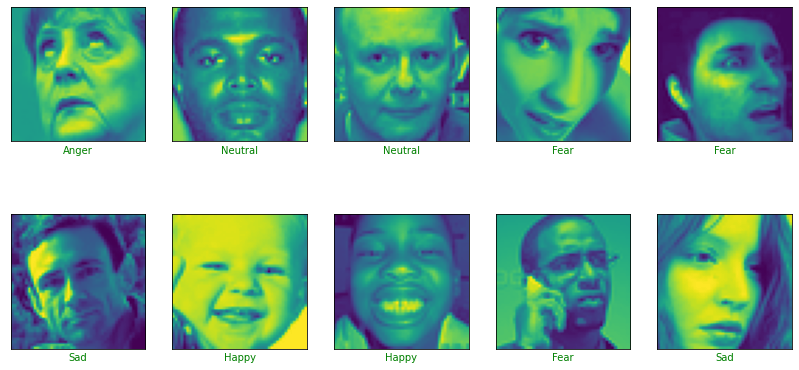

In [ ]:
show_random_examples(x_train, y_train, y_train)

In [ ]:
import os
DATADIR = "/content/facial-expression-dataset-image-folders/data"
DATATYPE = ['train', 'val', 'test']
CATEGORY = ['0', '1', '2', '3', '4', '5', '6']
path = DATADIR + "/" + DATATYPE[0];
for category in CATEGORY:
  cpath = path + "/" + category  
  print(str(len(os.listdir(cpath)))+ " " +class_names[int(category)] + " images")

3995 Anger images
436 Disgust images
4097 Fear images
7215 Happy images
4830 Sad images
3171 Surprise images
4965 Neutral images


In [ ]:
#CNN model
from keras.models import Model,Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,Input,Activation,GlobalAveragePooling2D
from keras.optimizers import Adam

nb_classes=7;

model=Sequential();
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)      

In [ ]:
history = model.fit(x_train/255, y_train,
                    validation_data = (x_val/255, y_val),
                    batch_size=150,
                    epochs=50,
                    shuffle=True
                    # callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
                    )

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 47s 2ms/step - loss: 2.0210 - accuracy: 0.2307 - val_loss: 1.8688 - val_accuracy: 0.1975
Epoch 2/50
28709/28709 [==============================] - 38s 1ms/step - loss: 1.8408 - accuracy: 0.2886 - val_loss: 1.9240 - val_accuracy: 0.1953
Epoch 3/50
28709/28709 [==============================] - 38s 1ms/step - loss: 1.7625 - accuracy: 0.3229 - val_loss: 1.8033 - val_accuracy: 0.2998
Epoch 4/50
28709/28709 [==============================] - 38s 1ms/step - loss: 1.6790 - accuracy: 0.3558 - val_loss: 1.7661 - val_accuracy: 0.3477
Epoch 5/50
28709/28709 [==============================] - 37s 1ms/step - loss: 1.6240 - accuracy: 0.3746 - val_loss: 1.6284 - val_accuracy: 0.3890
Epoch 6/50
28709/28709 [==============================] - 37s 1ms/step - loss: 1.5724 - accuracy: 0.3969 - val_loss: 1.6890 - val_accuracy: 0.3948
Epoch 7/50
28709/28709 [==============================] - 38s 1ms/ste

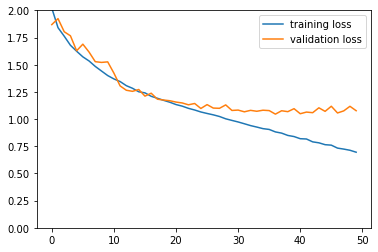

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.ylim([0, 2])
plt.show()

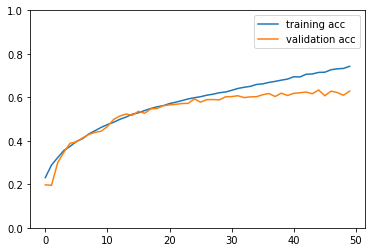

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc, label='training acc')
plt.plot(val_acc, label='validation acc')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [ ]:
model.evaluate(x_test/255, y_test)

3589/3589 [==============================] - 2s 611us/step


[1.0312562652303834, 0.646140992641449]

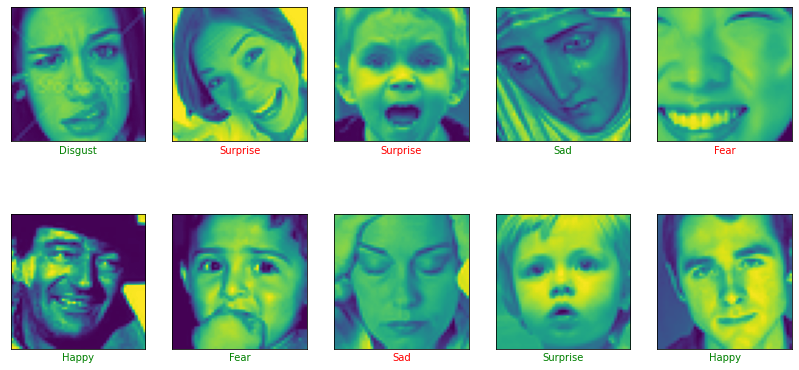

In [ ]:
predict=model.predict(x_test/255)
show_random_examples(x_test,y_test,predict)

In [ ]:
#model.save('/content/driver/My Drive/my_model_less_epoch.h5')

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

In [ ]:
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

In [ ]:
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")    


In [ ]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

#load model
model = model_from_json(open("fer.json", "r").read())
#load weights
model.load_weights('fer.h5')




In [ ]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

KeyboardInterrupt: ignored